# 04 Virtual point transformation (VPT)
With the `pyFBS` the aplication of the virtual point transformation (VPT) is simple. For more details on the virtual point transformation, refer to the documentation.

In [2]:
import pyFBS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Numerical example
First load a predefined datasets from an example directory. 

In [3]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6983.86it/s]

In [4]:
stl = r"./lab_testbench/STL/B.stl"
xlsx_pos = r"./lab_testbench/Measurements/AM_measurements.xlsx"

full_file = r"./lab_testbench/FEM/B.full"
ress_file = r"./lab_testbench/FEM/B.rst"

#### MK model
Prepeare a MK model for the FRF synthetization. For more details check-out the *03_FRF_synthetization.ipynb* example. 

In [5]:
MK = pyFBS.MK_model(ress_file,full_file,no_modes = 100,recalculate = False)

C:\Users\tomaz.bregar\Anaconda3\lib\site-packages\pyvista\core\pointset.py:610: UserWarning: VTK 9 no longer accepts an offset array
  warnings.warn('VTK 9 no longer accepts an offset array')


Add a STL and a coresponding mesh from FEM to the 3D view:

In [6]:
view3D = pyFBS.view3D(show_origin= True)
mesh = view3D.add_stl(stl,name = "engine_mount",color = "#8FB1CC",opacity = .1)
view3D.plot.add_mesh(MK.mesh, scalars = np.zeros(MK.mesh.points.shape[0]),show_scalar_bar = False,name = "mesh",cmap = "coolwarm",show_edges = True);

To evaluate the FEM model the mode shapes can be animated: 

In [7]:
select_mode = 6
_modeshape = MK.get_modeshape(select_mode)

mode_dict = pyFBS.utility.dict_animation(_modeshape,"modeshape",pts = MK.pts.copy(),mesh = MK.mesh)
view3D.add_modeshape(mode_dict,run_animation = True)

The mode shape deformation can also be cleared from the display:

In [8]:
view3D.clear_modeshape()

Load the channel and datasets.

In [9]:
df_imp = pd.read_excel(xlsx_pos, sheet_name='Impacts_B')
df_chn = pd.read_excel(xlsx_pos, sheet_name='Channels_B')

#view3D.show_imp(df_imp,overwrite = True)
#view3D.show_chn(df_chn)

Currently only "snap-to-node" FRF synthetization is supported. Therefore, the locations of the channels and impacts have to updated to snap to the nearest node from FEM model.

In [10]:
df_chn_up = MK.update_locations_df(df_chn)
df_imp_up = MK.update_locations_df(df_imp)

#view3D.show_chn(df_chn_up, color = "k",overwrite = False)
#view3D.show_imp(df_imp_up, color = "k",overwrite = False)

#### FRF synthetization
Finnaly the FRFs synthetization at the channel/impact DoFs:

In [11]:
MK.FRF_synth(df_chn_up,df_imp_up,f_start = 0,modal_damping = 0.003,frf_type = "accelerance")

## Virtual point transformation 
For the VPT the information on the position/orientation is required, together with the corresponding channel/impact information. Care should be take that the correct *Grouping* number is assigned to obtain the correct transformation. Currently only rigid body IDMs can be used in the transformation. 

In [12]:
df_vp = pd.read_excel(xlsx_pos, sheet_name='VP_Channels')
df_vpref = pd.read_excel(xlsx_pos, sheet_name='VP_RefChannels')

vpt = pyFBS.VPT(df_chn_up,df_imp_up,df_vp,df_vpref)

Final application of the VPT on the FRFs matrix is relatively simple:

In [13]:
vpt.apply_VPT(MK.freq,MK.FRF)

Display the FRFs from the new virtual DoFs:

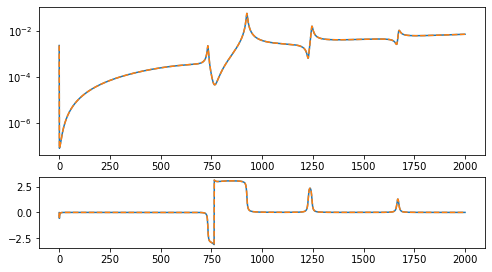

In [14]:
select_out = 5
select_in = 2

plt.figure(figsize = (8,6))
plt.subplot(211)
plt.semilogy(vpt.freq,np.abs(vpt.vptData[:,select_out,select_in]))
plt.semilogy(vpt.freq,np.abs(vpt.vptData[:,select_out,select_in]),'--',label = "filtered")

plt.subplot(413)
plt.plot(vpt.freq,np.angle(vpt.vptData[:,select_out,select_in]))
plt.plot(vpt.freq,np.angle(vpt.vptData[:,select_out,select_in]),'--',label = "filtered")

#### Consistency of the VPT
The evaluation of consistency of the VPT based on the grouping number:

In [15]:
vpt.consistency([1],[1])

Specific channel/sensor and impact consistency

Text(0.5, 1.0, 'Specific impact consistency')

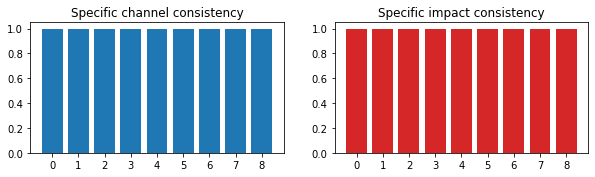

In [16]:
plt.figure(figsize = (10,2.4))
plt.subplot(121)
plt.bar(range(9),vpt.specific_sensor,color = "tab:blue")
plt.xticks(range(9))
plt.title("Specific channel consistency")

plt.subplot(122)
plt.bar(range(9),vpt.specific_impact,color = "tab:red")
plt.xticks(range(9));
plt.title("Specific impact consistency")

Overall channel/sensor and impact consistency

Text(0.5, 0, 'Frequency [Hz]')

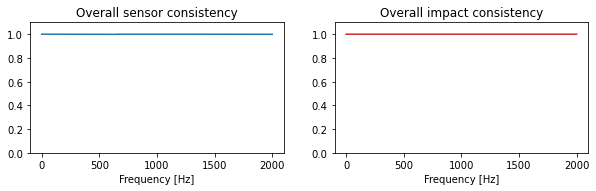

In [17]:
plt.figure(figsize = (10,2.4))
plt.subplot(121)
plt.plot(vpt.freq,vpt.overall_sensor,color = "tab:blue")
plt.ylim(0,1.1)
plt.title("Overall sensor consistency")
plt.xlabel("Frequency [Hz]")

plt.subplot(122)
plt.plot(vpt.freq,vpt.overall_impact,color = "tab:red")
plt.ylim(0,1.1)
plt.title("Overall impact consistency")
plt.xlabel("Frequency [Hz]")

Reciprocity check on the FRF matrix

Text(0, 0.5, 'Output DoFs')

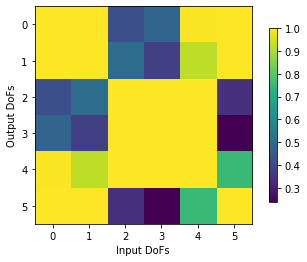

In [18]:
coh_crit = pyFBS.utility.coh_on_FRF(vpt.vptData[:,:6,:6])

plt.imshow(coh_crit)
plt.colorbar(shrink = 0.8)


plt.xlabel("Input DoFs")
plt.ylabel("Output DoFs")